<a href="https://colab.research.google.com/github/ThatCodeCodingGuy/Financial-Sentiment-Analysis-with-Machine-Learning-LSTM-and-BERT-Transformer/blob/main/eda%26scikit_learn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing Necessary Modules**

In [ ]:
import pandas as pd
import numpy as np
import re
import string

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import wordcloud

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, plot_confusion_matrix

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
#connecting to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Exploratory Data Analysis (EDA)**

In [ ]:
df = pd.read_csv('/content/finance.csv')
df.head(7)

,Unnamed: 0,Sentence,Sentiment
0,0,The GeoSolutions technology will leverage Bene...,positive
1,1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,2,"For the last quarter of 2010 , Componenta 's n...",positive
3,3,According to the Finnish-Russian Chamber of Co...,neutral
4,4,The Swedish buyout firm has sold its remaining...,neutral
5,5,$SPY wouldn't be surprised to see a green close,positive
6,6,Shell's $70 Billion BG Deal Meets Shareholder ...,negative


In [ ]:
df.drop("Unnamed: 0", axis=1, inplace=True) #dropping the unnecessary column

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5842 entries, 0 to 5841
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   5842 non-null   object
 1   Sentiment  5842 non-null   object
dtypes: object(2)
memory usage: 91.4+ KB


In [ ]:
df.isnull().sum()

Sentence     0
Sentiment    0
dtype: int64

In [ ]:
df.rename(columns={"Sentiment": "target", "Sentence": "data"}, inplace=True) #renaming the column names

In [ ]:
df['target'].value_counts()

neutral     3130
positive    1852
negative     860
Name: target, dtype: int64

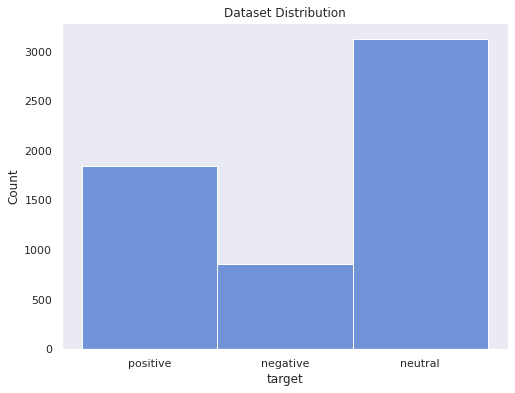

In [ ]:
plt.figure(figsize=(8,6))
plt.title('Dataset Distribution')
sns.set(color_codes=True)
sns.set(style="dark", palette="muted")
sns.histplot(df['target'])
plt.show()

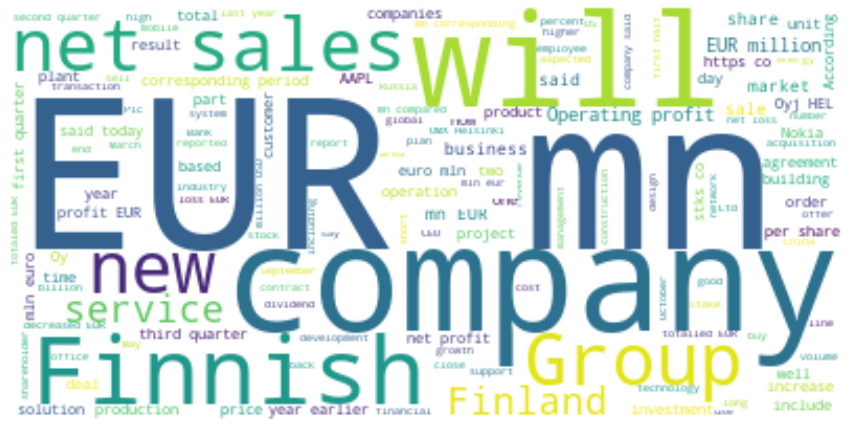

In [ ]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS
from wordcloud import ImageColorGenerator
text = " ".join(i for i in df.data)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
df.head(7)

,data,target
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral
5,$SPY wouldn't be surprised to see a green close,positive
6,Shell's $70 Billion BG Deal Meets Shareholder ...,negative


In [ ]:
df['target'] = df['target'].map({'negative': -1, 'neutral': 0, 'positive': 1}) #changing the values of the "target" column to integers

In [ ]:
df.head(7)

# **Data Cleaning**

In [ ]:
def clean_text(text):
  '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
  # make text lowercase
  text = text.lower()
  # removing text within brackets
  text = re.sub('\[.*?\]', '', text)
  # removing text within parentheses
  text = re.sub('\(.*?\)', '', text)
  # removing numbers
  text = re.sub('\w*\d\w*', '', text)
  # if there's more than 1 whitespace, then make it just 1
  text = re.sub('\s+', ' ', text)
  # if there's a new line, then make it a whitespace
  text = re.sub('\n', ' ', text)
  # removing any quotes
  text = re.sub('\"+', '', text)
  # removing &amp;
  text = re.sub('(\&amp\;)', '', text)
  # removing any usernames
  text = re.sub('(@[^\s]+)', '', text)
  # removing any hashtags
  text = re.sub('(#[^\s]+)', '', text)
  # remove `rt` for retweet
  text = re.sub('(rt)', '', text)
  # string.punctuation is a string of all punctuation marks
  # so this gets rid of all punctuation
  text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
  # getting rid of `httptco`
  text = re.sub('(httptco)', '', text)

  return text

round = lambda x: clean_text(x)

In [ ]:
df['data'] = df['data'].apply(clean_text)
df.head(7)

,data,target
0,the geosolutions technology will leverage bene...,1
1,esi on lows down to bk a real possibility,-1
2,for the last quaer of componenta s net sales ...,1
3,according to the finnishrussian chamber of com...,0
4,the swedish buyout firm has sold its remaining...,0
5,spy wouldnt be surprised to see a green close,1
6,shells billion bg deal meets shareholder skep...,-1


In [ ]:
#tokenization with stopwords removing
stop_words = set(stopwords.words('english'))
def process_text(text):
  tokens = nltk.word_tokenize(text)
  removed_stopwords = [token.lower() for token in tokens if token.lower() not in stop_words]
  return removed_stopwords

In [ ]:
processed_data = list(map(process_text, df['data']))

In [ ]:
#lemmatization
lemmatizer = WordNetLemmatizer()
lemmatized_output = []
for listy in processed_data:
  lemmed = ' '.join([lemmatizer.lemmatize(w) for w in listy])
  lemmatized_output.append(lemmed)

In [ ]:
X_lem = lemmatized_output
y_lem = df['target']

# **Train-Test Split & Vectorization**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_lem, y_lem, test_size=0.20, random_state=15)

In [ ]:
tfidf = TfidfVectorizer(stop_words=stop_words)

In [ ]:
X_train = tfidf.fit_transform(X_train).toarray()
X_test = tfidf.transform(X_test).toarray()

# **Models**

# **Naive Bayes**

In [ ]:
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(X_train, y_train)

GaussianNB()

In [ ]:
y_pred = classifier.predict(X_test)

In [ ]:
NB_precision = precision_score(y_test, y_pred, average='micro')
NB_recall = recall_score(y_test, y_pred, average='micro')
NB_f1_score = f1_score(y_test, y_pred, average='micro')
NB_weighted_f1_score = f1_score(y_test, y_pred, average='weighted')
NB_acc1 = accuracy_score(y_test, y_pred)

In [ ]:
print('Testing Metrics for NB Baseline with Lemmatization Features')
print('Precision: {:.4}'.format(NB_precision))
print('Recall: {:.4}'.format(NB_recall))
print('F1 Score: {:.4}'.format(NB_f1_score))
print('Weighted F1 Score: {:.4}'.format(NB_weighted_f1_score))
print('Accuracy Score: {:.4}'.format(NB_acc1))

Testing Metrics for NB Baseline with Lemmatization Features
Precision: 0.521
Recall: 0.521
F1 Score: 0.521
Weighted F1 Score: 0.5358
Accuracy Score: 0.521


# **Multinomial Naive Bayes**

In [ ]:
from sklearn.naive_bayes import MultinomialNB
classifier=MultinomialNB()

In [ ]:
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

In [ ]:
MultiNB_precision = precision_score(y_test, y_pred, average='micro')
MultiNB_recall = recall_score(y_test, y_pred, average='micro')
MultiNB_f1_score = f1_score(y_test, y_pred, average='micro')
MultiNB_weighted_f1_score = f1_score(y_test, y_pred, average='weighted')
MultiNB_acc1 = accuracy_score(y_test, y_pred)

In [ ]:
print('Testing Metrics for MultiNB Baseline with Lemmatization Features')
print('Precision: {:.4}'.format(MultiNB_precision))
print('Recall: {:.4}'.format(MultiNB_recall))
print('F1 Score: {:.4}'.format(MultiNB_f1_score))
print('Weighted F1 Score: {:.4}'.format(MultiNB_weighted_f1_score))
print('Accuracy Score: {:.4}'.format(MultiNB_acc1))

Testing Metrics for MultiNB Baseline with Lemmatization Features
Precision: 0.6501
Recall: 0.6501
F1 Score: 0.6501
Weighted F1 Score: 0.5843
Accuracy Score: 0.6501


# **Logistic Regression**

In [ ]:
regression = LogisticRegression(solver='liblinear', max_iter=1000)

In [ ]:
regression.fit(X_train, y_train)
predicts = regression.predict(X_test)

In [ ]:
logreg_precision = precision_score(y_test, predicts, average='micro')
logreg_recall = recall_score(y_test, predicts, average='micro')
logreg_f1_score = f1_score(y_test, predicts, average='micro')
logreg_weighted_f1_score = f1_score(y_test, predicts, average='weighted')
logreg_acc1 = accuracy_score(y_test, y_pred)

In [ ]:
print('Testing Metrics for Logistic Regression Baseline with Lemmatization Features')
print('Precision: {:.4}'.format(logreg_precision))
print('Recall: {:.4}'.format(logreg_recall))
print('F1 Score: {:.4}'.format(logreg_f1_score))
print('Weighted F1 Score: {:.4}'.format(logreg_weighted_f1_score))
print('Accuracy: {:.4}'.format(logreg_acc1))

Testing Metrics for Logistic Regression Baseline with Lemmatization Features
Precision: 0.6698
Recall: 0.6698
F1 Score: 0.6698
Weighted F1 Score: 0.6311
Accuracy: 0.6501


# **Support Vector Machine**

In [ ]:
from sklearn.svm import LinearSVC

In [ ]:
classifier = LinearSVC()

In [ ]:
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

In [ ]:
SVC_precision = precision_score(y_test, y_pred, average='micro')
SVC_recall = recall_score(y_test, y_pred, average='micro')
SVC_f1_score = f1_score(y_test, y_pred, average='micro')
SVC_weighted_f1_score = f1_score(y_test, y_pred, average='weighted')
SVC_acc1 = accuracy_score(y_test, y_pred)

In [ ]:
print('Testing Metrics for SVM Baseline with Lemmatization Features')
print('Precision: {:.4}'.format(SVC_precision))
print('Recall: {:.4}'.format(SVC_recall))
print('F1 Score: {:.4}'.format(SVC_f1_score))
print('Weighted F1 Score: {:.4}'.format(SVC_weighted_f1_score))
print('Accuracy Score: {:.4}'.format(SVC_acc1))

Testing Metrics for SVM Baseline with Lemmatization Features
Precision: 0.6681
Recall: 0.6681
F1 Score: 0.6681
Weighted F1 Score: 0.6572
Accuracy Score: 0.6681


# **XGBoost Model**

In [ ]:
from xgboost import XGBClassifier
classifier = XGBClassifier()
classifier.fit(X_train, y_train)

XGBClassifier(objective='multi:softprob')

In [ ]:
preds = classifier.predict(X_test)

In [ ]:
xgb_precision = precision_score(y_test, preds, average='micro')
xgb_recall = recall_score(y_test, preds, average='micro')
xgb_f1 = f1_score(y_test, preds, average='micro')
xgb_weighted_f1 = f1_score(y_test, preds, average='weighted')
xgb_acc1 = accuracy_score(y_test, y_pred)

In [ ]:
print('Testing XGBoost Scores')
print('Precision {:.4}'.format(xgb_precision))
print('Recall {:.4}'.format(xgb_recall))
print('F1 Score {:.4}'.format(xgb_f1))
print('Weighted F1 Score {:.4}'.format(xgb_weighted_f1))
print('Accuracy {:.4}'.format(xgb_acc1))

Testing XGBoost Scores
Precision 0.6433
Recall 0.6433
F1 Score 0.6433
Weighted F1 Score 0.5815
Accuracy 0.6681


# **Results**

In [ ]:
metric_dict= {} #making an empty dict for the metric results
metric_dict['Naive Bayes'] = {'precision': NB_precision, 'recall': NB_recall, 'f1_score': NB_f1_score, 'weighted_f1': NB_weighted_f1_score, 'accuracy': NB_acc1}
metric_dict['Multinomial NB'] = {'precision': MultiNB_precision, 'recall': MultiNB_recall, 'f1_score': MultiNB_f1_score, 'weighted_f1': MultiNB_weighted_f1_score, 'accuracy': MultiNB_acc1}
metric_dict['Baseline Logistic Regression'] = {'precision': logreg_precision, 'recall': logreg_recall, 'f1_score': logreg_f1_score, 'weighted_f1': logreg_weighted_f1_score, 'accuracy': logreg_acc1}
metric_dict['Linear SVC'] = {'precision': SVC_precision, 'recall': SVC_recall, 'f1_score': logreg_f1_score, 'weighted_f1': SVC_weighted_f1_score, 'accuracy': SVC_acc1}
metric_dict['XGBoost'] = {'precision': xgb_precision, 'recall': xgb_recall, 'f1_score': xgb_f1, 'weighted_f1': xgb_weighted_f1, 'accuracy': xgb_acc1}

In [ ]:
pd.DataFrame.from_dict(metric_dict, orient='index')

,precision,recall,f1_score,weighted_f1,accuracy
Naive Bayes,0.520958,0.520958,0.520958,0.535846,0.520958
Multinomial NB,0.650128,0.650128,0.650128,0.584311,0.650128
Baseline Logistic Regression,0.669803,0.669803,0.669803,0.631149,0.650128
Linear SVC,0.668092,0.668092,0.669803,0.657212,0.668092
XGBoost,0.643285,0.643285,0.643285,0.581529,0.668092
